# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
import zipfile
with zipfile.ZipFile('UCI HAR Dataset.zip', 'r') as zip_f:
  zip_f.extractall()

!ls

 cnn_clean.keras    lstm_full_new.keras    sample_data
 cnn_masked.keras   lstm_incom.keras	  'UCI HAR Dataset'
 cnn_noised.keras   lstm_incom_new.keras  'UCI HAR Dataset.zip'
 lstm_full.keras    __MACOSX


In [3]:
data_path = Path('UCI HAR Dataset')
train_path = data_path / 'train' / 'Inertial Signals'
test_path = data_path / 'test' / 'Inertial Signals'

def load_signal(file_path):
  return np.loadtxt(file_path)

#Train

In [4]:
signal_train = {
    'acc_x': load_signal(train_path/'body_acc_x_train.txt'),
    'acc_y': load_signal(train_path/'body_acc_y_train.txt'),
    'acc_z': load_signal(train_path/'body_acc_z_train.txt'),
    'gyro_x': load_signal(train_path/'body_gyro_x_train.txt'),
    'gyro_y': load_signal(train_path/'body_gyro_y_train.txt'),
    'gyro_z': load_signal(train_path/'body_gyro_z_train.txt'),
}

In [ ]:
for name, signal in signal_train.items():
  print(f'{name}: {signal.shape}')

acc_x: (7352, 128)
acc_y: (7352, 128)
acc_z: (7352, 128)
gyro_x: (7352, 128)
gyro_y: (7352, 128)
gyro_z: (7352, 128)


Формирование 3D тензора



In [5]:
X_train = np.stack(
    [
        signal_train['acc_x'],
        signal_train['acc_y'],
        signal_train['acc_z'],
        signal_train['gyro_x'],
        signal_train['gyro_y'],
        signal_train['gyro_z']

    ],
    axis=-1
)

In [ ]:
X_train.shape

(7352, 128, 6)

In [6]:
y_train = pd.read_csv(
    data_path/'train'/'y_train.txt',
    header=None,
    names=['activity']
)


In [ ]:
y_train

,activity
0,5
1,5
2,5
3,5
4,5
...,...
7347,2
7348,2
7349,2
7350,2


Преобразуем метки с 0-5 для ML (было 1-6)

In [7]:
y_train['activity'] = y_train['activity'] - 1

In [ ]:
y_train['activity'].value_counts().sort_index()

,count
activity,
0,1226
1,1073
2,986
3,1286
4,1374
5,1407


Данные умеренно несбалансированны, следовательно используем стандартные метрики качества

## EDA

### Distribution of activity class




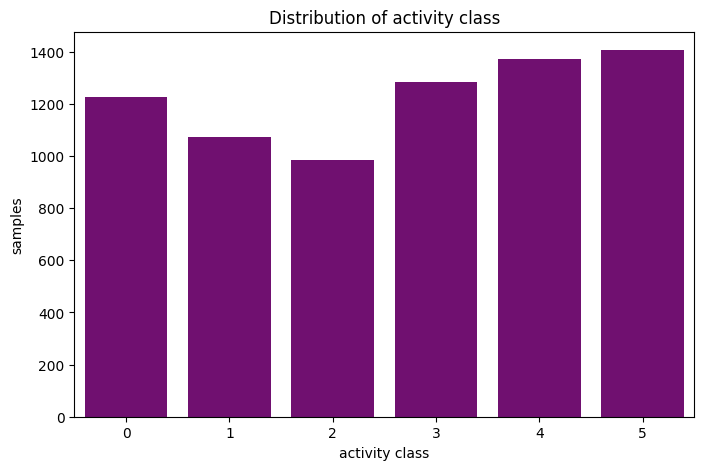

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x = y_train['activity'], color= 'purple')
plt.title('Distribution of activity class')
plt.xlabel('activity class')
plt.ylabel('samples')
plt.show()

* Активности представлены относительно равномерно

* Критического дисбаланса классов не наблюдается

### Time series visualization

In [8]:
activity_ex = {}
for activity in y_train['activity'].unique():
  idx = y_train[y_train['activity'] == activity].index[0]
  activity_ex[activity] = X_train[idx]


In [ ]:
for activity, signal in activity_ex.items():
  print(activity, signal)

4 [[ 1.808515e-04  1.076681e-02  5.556068e-02  3.019122e-02  6.601362e-02
   2.285864e-02]
 [ 1.013856e-02  6.579480e-03  5.512483e-02  4.371071e-02  4.269897e-02
   1.031572e-02]
 [ 9.275574e-03  8.928878e-03  4.840473e-02  3.568780e-02  7.485018e-02
   1.324969e-02]
 [ 5.065897e-03  7.488683e-03  4.977497e-02  4.040210e-02  5.731974e-02
   1.775121e-02]
 [ 1.081025e-02  6.140966e-03  4.301314e-02  4.709654e-02  5.234284e-02
   2.553367e-03]
 [ 4.045101e-03  6.944317e-03  4.472929e-02  5.018473e-02  6.917394e-02
   7.724708e-03]
 [ 4.757375e-03  3.552423e-03  4.371898e-02  5.054452e-02  4.986670e-02
   4.324535e-03]
 [ 6.213647e-03  2.537128e-03  3.537854e-02  4.499207e-02  5.675081e-02
   1.061698e-02]
 [ 3.306744e-03  4.084532e-03  3.118777e-02  4.768623e-02  5.818872e-02
   1.718869e-02]
 [ 7.571941e-03  5.118448e-03  2.356719e-02  4.681215e-02  4.319882e-02
   1.051070e-02]
 [ 5.407117e-03  5.892268e-03  2.100047e-02  4.648827e-02  5.577766e-02
   1.509803e-02]
 [ 6.221276e-03  7.

In [9]:
activity_labels = {
    0: 'Walking',
    1: 'Walking upstairs',
    2: 'Walking downstairs',
    3: 'Sitting',
    4: 'Standing',
    5: 'Lying'
}

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for activity, signal in activity_ex.items():
  fig.add_trace(
      go.Scatter(
          y = signal[:, 0],
          mode = 'lines',
          name = activity_labels.get(activity, f'Activity {activity}')
      )
  )

fig.update_layout(
    title = dict(
        text = 'Accelerometer signals for different activities'
    ),
    xaxis_title = 'time step',
    yaxis_title = 'acceleration'
)

fig.show()

Можно заметить, что динамические активности характеризуются большей амплитудой и частотой колебаний сигнала, в то время как статические активности имеют более стабильный характер

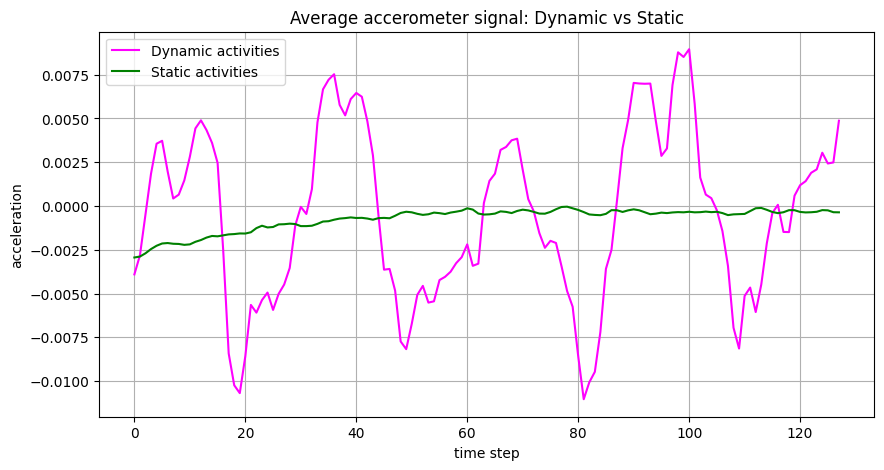

In [ ]:
dynamic_class = [0, 1, 2] #walking
static_class = [3, 4, 5] #sitting/standing/laying

dynamic_signal = X_train[
    y_train['activity'].isin(dynamic_class).values
][:,:,0].mean(axis=0)
static_signal = X_train[
    y_train['activity'].isin(static_class).values
][:,:,0].mean(axis=0)

plt.figure(figsize=(10,5))
plt.plot(dynamic_signal, label='Dynamic activities', color = 'fuchsia')
plt.plot(static_signal, label='Static activities', color = 'green')
plt.title('Average accerometer signal: Dynamic vs Static')
plt.xlabel('time step')
plt.ylabel('acceleration')
plt.grid(True)
plt.legend()
plt.show()

Усредненные сигналы показывают существенные различия между динамическими и статическими активностями, что подтверждает информативность сенсорных данных

## Частичная потеря сенсорной информации
**Reconstruction/Создание неполных данных**

Восстановим состояние активности при потере одного из сенсоров (гироскоп)

    В условиях реальной жизни гироскоп может разрядить батарею, работать нестабильно или отсутствовать в бюджетных альтернативах устройства, поэтому остается только акселерометр.



In [10]:
X_train_incomplete = X_train[:, :,:3]

In [ ]:
X_train.shape, X_train_incomplete.shape

((7352, 128, 6), (7352, 128, 3))

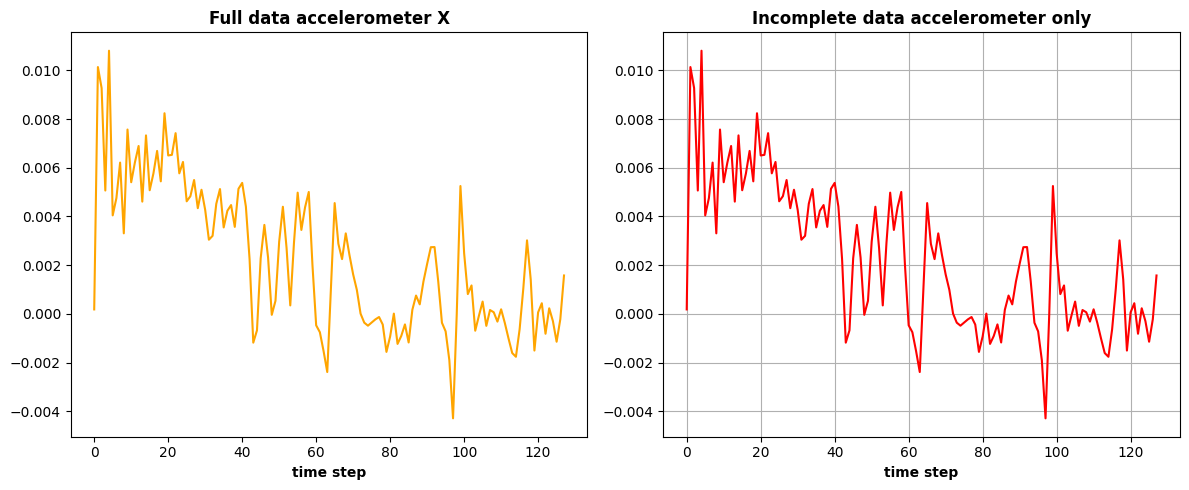

In [ ]:
sample_idx = 0

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(X_train[sample_idx, :, 0], color = 'orange')
plt.title('Full data accelerometer X', fontweight = 'bold')
plt.xlabel('time step', fontweight = 'bold')

plt.subplot(1, 2, 2)
plt.plot(X_train_incomplete[sample_idx, :, 0], color = 'red')
plt.title('Incomplete data accelerometer only', fontweight = 'bold')
plt.xlabel('time step', fontweight = 'bold')

plt.grid(True)
plt.tight_layout()
plt.show()

Несмотря на удаление одного из источников сенсорной информации, акселерометр сохраняет информацию о динамике движение.

#Test

In [11]:
signal_test = {
    'acc_x': load_signal(test_path/'body_acc_x_test.txt'),
    'acc_y': load_signal(test_path/'body_acc_y_test.txt'),
    'acc_z': load_signal(test_path/'body_acc_z_test.txt'),
    'gyro_x': load_signal(test_path/'body_gyro_x_test.txt'),
    'gyro_y': load_signal(test_path/'body_gyro_y_test.txt'),
    'gyro_z': load_signal(test_path/'body_gyro_z_test.txt'),
}

X_test = np.stack(
    [
        signal_test['acc_x'],
        signal_test['acc_y'],
        signal_test['acc_z'],
        signal_test['gyro_x'],
        signal_test['gyro_y'],
        signal_test['gyro_z']

    ],
    axis=-1
)

y_test = pd.read_csv(
    data_path/'test'/'y_test.txt',
    header=None,
    names=['activity']
)
y_test['activity'] = y_test['activity'] - 1

In [12]:
X_test_incomplete = X_test[:, :,:3]

In [ ]:
X_train.shape, X_test.shape, X_train_incomplete.shape, X_test_incomplete.shape

((7352, 128, 6), (2947, 128, 6), (7352, 128, 3), (2947, 128, 3))

На основе baseline делаем вывод, что потеря сенсора вредит и его данные информативны.

Постараемся компенсировать потерю информации за счет временной динамики.

## Baseline

Рассматриваем данные БЕЗ features, в данном случае имитация/вручную извлечение простейших признаков mean / std по каждому сигналу.

In [13]:
def extract_features(X):
  features = []

  for sample in X:
    sample_features = []
    for channel in range(sample.shape[1]):
      sample_features.append(sample[:, channel].mean())
      sample_features.append(sample[:, channel].std())
    features.append(sample_features)

  return np.array(features)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

#FULL
X_full = extract_features(X_train)
X_test_full = extract_features(X_test)

baseline_full = LogisticRegression(max_iter=1000)
baseline_full.fit(X_full, y_train['activity'])

y_pred_full = baseline_full.predict(X_test_full)
baseline_acc_full = accuracy_score(y_test['activity'], y_pred_full)

print('Baseline - full data')
print('Accuracy:', round(baseline_acc_full, 3))
print('F1 score:', round(f1_score(y_test['activity'], y_pred_full, average = 'weighted'), 3))

#INCOMPLETE
X_incomplete = extract_features(X_train_incomplete)
X_incomplete_test = extract_features(X_test_incomplete)
baseline_incom = LogisticRegression(max_iter=1000)
baseline_incom.fit(X_incomplete, y_train['activity'])

y_pred_incom = baseline_incom.predict(X_incomplete_test)
baseline_acc_incom = accuracy_score(y_test['activity'], y_pred_incom)

print('\nBaseline - incomplete data')
print('Accuracy:', round(baseline_acc_incom, 3))
print('F1 score:', round(f1_score(y_test['activity'], y_pred_incom, average = 'weighted'), 3))

Baseline - full data
Accuracy: 0.606
F1 score: 0.608

Baseline - incomplete data
Accuracy: 0.551
F1 score: 0.488


На основе baseline делаем вывод, что потеря сенсора вредит и его данные информативны.

Постараемся компенсировать потерю информации за счет временной динамики.

## LSTM - обучение модели

В этом проекте LSTM была выбрана для моделирования временных зависимостей в многомерных сигналах акселерометра, где порядок и динамика измерений информативны для распознавания активности.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical


y_train_cat = to_categorical(y_train['activity'], num_classes = 6)
y_test_cat = to_categorical(y_test['activity'], num_classes = 6)

Обучаем модель

In [ ]:
model_full = Sequential([
    Input(shape = (128, 6)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation = 'softmax')
])

model_full.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_full = model_full.fit(
    X_train,
    y_train_cat,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    verbose = 1
)

model_full.save('lstm_full.keras')

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2939 - loss: 1.7309 - val_accuracy: 0.3372 - val_loss: 1.6307
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.3337 - loss: 1.5003 - val_accuracy: 0.3304 - val_loss: 1.2867
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3430 - loss: 1.3449 - val_accuracy: 0.3304 - val_loss: 1.2631
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.3478 - loss: 1.2693 - val_accuracy: 0.3644 - val_loss: 1.1713
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.3980 - loss: 1.1762 - val_accuracy: 0.3426 - val_loss: 1.2989
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3693 - loss: 1.3487 - val_accuracy: 0.4099 - val_loss: 1.1537
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.4368 - loss: 1.1581 - val_accuracy: 0.4215 - val_loss: 1.1800
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.4216 - loss: 1.1688 - val_accuracy: 0.4582 -

loss падает и accuracy растет => LMTS успешно обучается и способна извлекать временные паттерны из последовательностей сенсорных данные.

In [ ]:
model_full = load_model('lstm_full.keras')

In [ ]:
test_loss_full, test_acc_full = model_full.evaluate(X_test, y_test_cat)
print(f'LMTS full data test accuracy: {round(test_acc_full, 3)}')
print(f'LMTS full data test loss: {round(test_loss_full, 3)}')

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4708 - loss: 1.0397
LMTS full data test accuracy: 0.475
LMTS full data test loss: 1.048


Incomplete data

In [ ]:
model_incomplete = Sequential([
    Input(shape = (128, 3)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation = 'softmax')
])

model_incomplete.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_incomplete = model_incomplete.fit(
    X_train_incomplete,
    y_train_cat,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    verbose = 1
)

model_incomplete.save('lstm_incom.keras')

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.2880 - loss: 1.7228 - val_accuracy: 0.3351 - val_loss: 1.3565
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.2984 - loss: 1.4446 - val_accuracy: 0.3562 - val_loss: 1.3054
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.3507 - loss: 1.2607 - val_accuracy: 0.3385 - val_loss: 1.1326
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3435 - loss: 1.1608 - val_accuracy: 0.3345 - val_loss: 1.1624
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.3432 - loss: 1.1658 - val_accuracy: 0.3447 - val_loss: 1.1159
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.3445 - loss: 1.1249 - val_accuracy: 0.3447 - val_loss: 1.1102
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.3440 - loss: 1.1303 - val_accuracy: 0.3385 - val_loss: 1.1127
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.3610 - loss: 1.1114 - val_accuracy: 0.3549

In [ ]:
model_incomplete = load_model('lstm_incom.keras')

In [ ]:
test_loss_incom, test_acc_incom = model_incomplete.evaluate(
    X_test_incomplete, y_test_cat
    )
print(f'LMTS incomplete data test accuracy: {round(test_acc_incom, 3)}')
print(f'LMTS incomplete data test loss: {round(test_loss_incom, 3)}')

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3387 - loss: 1.1401
LMTS incomplete data test accuracy: 0.342
LMTS incomplete data test loss: 1.132


full data test accuracy: 0.475 > incomplete data test accuracy: 0.342

full data test loss: 1.048 < incomplete data test loss: 1.132

Даже при использовании моделей, учитывающих временную структуру данных, потеря гироскопа приводит к снижению качества распознавания активностей.

## Confusion matrix и анализ ошибок

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_full = np.argmax(model_full.predict(X_test), axis=1)
y_pred_incom = np.argmax(model_incomplete.predict(X_test_incomplete), axis=1)

cm_full = confusion_matrix(y_test['activity'], y_pred_full)
cm_incom = confusion_matrix(y_test['activity'], y_pred_incom)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


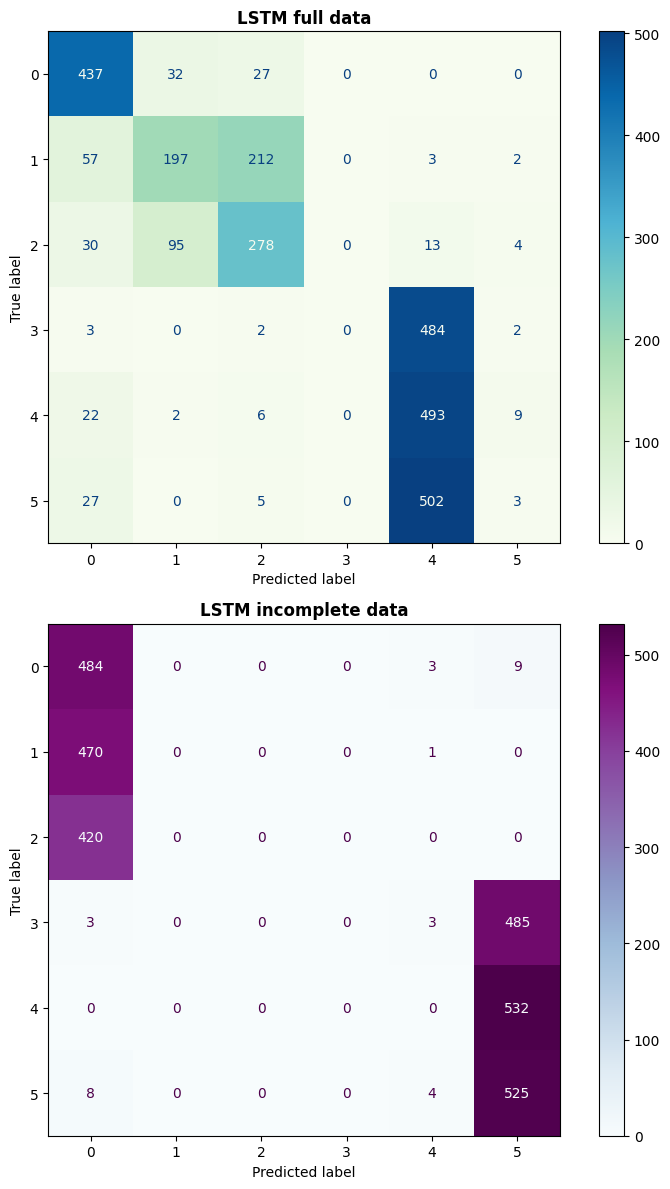

In [ ]:
plt.figure(figsize=(8,12))
plt.subplot(2, 1, 1)
ConfusionMatrixDisplay(cm_full).plot(cmap = 'GnBu', ax=plt.gca())
plt.title('LSTM full data', fontweight = 'bold')

plt.subplot(2, 1, 2)
ConfusionMatrixDisplay(cm_incom).plot(cmap = 'BuPu', ax=plt.gca())
plt.title('LSTM incomplete data', fontweight = 'bold')

plt.tight_layout()
plt.show()

Анализ матриц ошибок показывает, что при отсутствии гироскопических данных модель чаще путает схожие по динамике активности, такие как WALKING_UPSTAIRS и WALKING_DOWNSTAIRS. Это свидетельствует о важности угловых скоростей для точного восстановления состояния движения.

## Нормализация по времени





Так как у нас очень низкий accuracy
1. нормализуем по времени выборку (мы не будем нормалицовать по всей выборке, так как это сломает временную структуру)


*   акселерометр = (X, Y, Z)
*   гироскоп = (X, Y, Z)

samples, time steps, channels

=> делаем Z-score нормалицазию по каждому каналу отдельно

2. добавим производные функции, это не будет добавление новый сенсорных сигналов, это будет выжимка физического смысла из существующих.

для акселерометра:

$ ∣a∣=√(a_x^2+a_y^2+a_z^2 )$

для гироскопа:

$ ∣ω∣=√(ω_x^2+ω_y^2+ω_z^2 )$

In [ ]:
def add_features(X, Gyro = True):
  '''
  X: samples, time steps, channels
  Gyro: True for full data, False for incomplete
  '''

  acc = X[:,:,0:3]
  acc_add = np.linalg.norm(acc, axis=2, keepdims = True)

  if Gyro:
    gyro = X[:,:,3:6]
    gyro_add = np.linalg.norm(gyro, axis=2, keepdims = True)
    X_new = np.concatenate([X, acc_add, gyro_add], axis = 2)
  else:
    X_new = np.concatenate([X, acc_add], axis = 2)
  return X_new

In [ ]:
X_train_full = add_features(X_train, Gyro = True)
X_test_full = add_features(X_test, Gyro = True)

X_train_incom = add_features(X_train_incomplete, Gyro = False)
X_test_incom = add_features(X_test_incomplete, Gyro = False)

In [ ]:
def norm_per_channel(Xtrain, Xtest):
  '''
  Z-score
  '''

  mean = Xtrain.mean(axis = (0, 1), keepdims = True)
  std = Xtrain.std(axis = (0, 1), keepdims = True ) + 1e-8

  X_train_norm = (Xtrain - mean) / std
  X_test_norm = (Xtest - mean) / std

  return X_train_norm, X_test_norm

In [ ]:
Xtrain_full, Xtest_full = norm_per_channel(X_train_full, X_test_full)
Xtrain_incom, Xtest_incom = norm_per_channel(X_train_incom, X_test_incom)

In [ ]:
model_full_new = Sequential([
    Input(shape = (128, 8)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation = 'softmax')
])

model_full_new.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
history_full_new = model_full_new.fit(
    Xtrain_full,
    y_train_cat,
    validation_data = (Xtest_full, y_test_cat),
    epochs = 10,
    batch_size = 64
)

model_full_new.save('lstm_full_new.keras')

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.3681 - loss: 1.4491 - val_accuracy: 0.5602 - val_loss: 0.8648
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5820 - loss: 0.8003 - val_accuracy: 0.6111 - val_loss: 0.7427
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.6166 - loss: 0.6797 - val_accuracy: 0.6345 - val_loss: 0.7455
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.6285 - loss: 0.6350 - val_accuracy: 0.6176 - val_loss: 0.7481
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6310 - loss: 0.6348 - val_accuracy: 0.6393 - val_loss: 0.6559
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6311 - loss: 0.6337 - val_accuracy: 0.6315 - val_loss: 0.6918
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.6312 - loss: 0.6194 - val_accuracy: 0.6216 - val_loss: 0.7521
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.6385 - loss: 0.6308 - val_a

In [ ]:
model_full_new = load_model('lstm_full_new.keras')

In [ ]:
test_loss_full_new, test_acc_full_new = model_full_new.evaluate(
    Xtest_full, y_test_cat)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6218 - loss: 0.7384




---



In [ ]:
model_incom_new = Sequential([
    Input(shape = (128, 4)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(6, activation = 'softmax')
])

model_incom_new.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history_incom_new = model_incom_new.fit(
    Xtrain_incom,
    y_train_cat,
    validation_data = (Xtest_incom, y_test_cat),
    epochs = 10,
    batch_size = 64)

model_incom_new.save('lstm_incom_new.keras')

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.3452 - loss: 1.4031 - val_accuracy: 0.4360 - val_loss: 1.0365
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.5048 - loss: 0.9189 - val_accuracy: 0.5473 - val_loss: 0.9084
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5747 - loss: 0.7900 - val_accuracy: 0.5680 - val_loss: 0.8020
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5954 - loss: 0.7236 - val_accuracy: 0.5972 - val_loss: 0.7869
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6146 - loss: 0.6939 - val_accuracy: 0.6149 - val_loss: 0.7470
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6152 - loss: 0.6700 - val_accuracy: 0.5999 - val_loss: 0.7232
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.6271 - loss: 0.6493 - val_accuracy: 0.6074 - val_loss: 0.7598
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.6150 - loss: 0.6531 - val_a

In [ ]:
model_incom_new = load_model('lstm_incom_new.keras')

In [ ]:
test_loss_incom_new, test_acc_incom_new = model_incom_new.evaluate(
    Xtest_incom, y_test_cat)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6027 - loss: 0.7445


In [ ]:
results = pd.DataFrame({
    'Model': [
        'Baseline (full data)',
        'Baseline (incomplete data)',
        'LSTM (full data)',
        'LSTM (incomplete data)',
        'LSTM norm (full data)',
        'LSTM norm (incomplete data)'
    ],
    'Accuracy':[
        baseline_acc_full,
        baseline_acc_incom,
        test_acc_full,
        test_acc_incom,
        test_acc_full_new,
        test_acc_incom_new
    ]
})

results

,Model,Accuracy
0,Baseline (full data),0.608814
1,Baseline (incomplete data),0.547470
2,LSTM (full data),0.477774
3,LSTM (incomplete data),0.342382
4,LSTM norm (full data),0.647438
5,LSTM norm (incomplete data),0.621310


 Потеря гироскопа приводит к резкому ухудшению качества LSTM, что указывает на критическую роль угловой динамики для реконструкции активности.

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


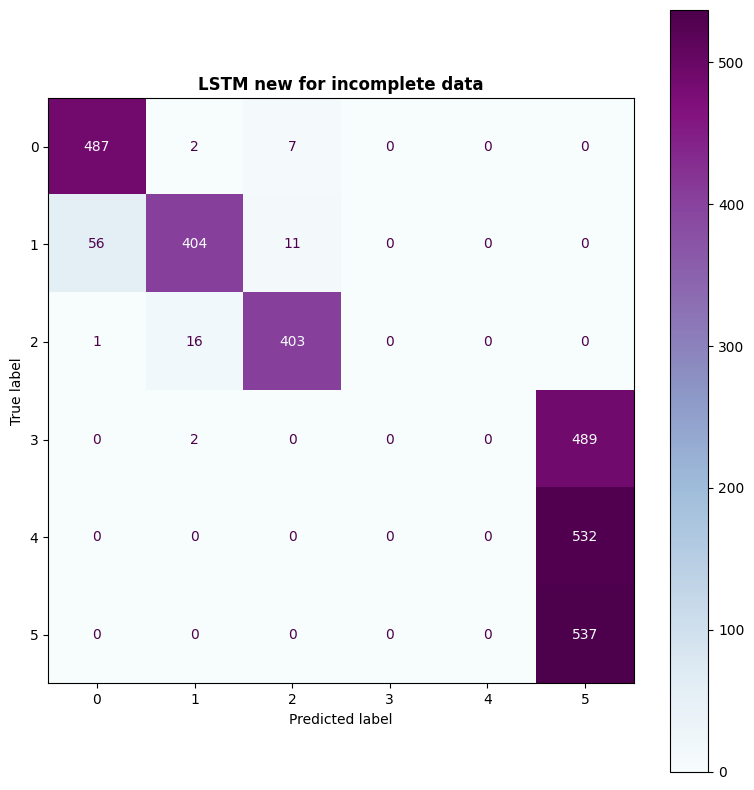

In [ ]:
y_pred_incom_new = np.argmax(model_incom_new.predict(Xtest_incom), axis=1)
cm_incom_new = confusion_matrix(y_test['activity'], y_pred_incom_new)

plt.figure(figsize=(8,8))

ConfusionMatrixDisplay(cm_incom_new).plot(cmap = 'BuPu', ax=plt.gca())
plt.title('LSTM new for incomplete data', fontweight = 'bold')

plt.tight_layout()
plt.show()

**Вывод:** после некоторых манипуляций с данными, accuracy улучшает качество, даже при потере гироскопа. Модель сохраняет способность корректно восстанавливать состояние активности.

# Complex Features

На данном этапе буду использовать альтернативное представление данных. В отличие от предыдущего блока, каждый sample здесь будет представлен в виде вектора из 516 признаков.

По данным датасета признаки нормализованы и лежат в диапазоне от -1 до 1. Поэтому я буду использовать стандартные алгоритмы без масштабирования.

In [16]:
X_train_features = pd.read_csv(data_path/'train'/'X_train.txt', header=None, sep = r'\s+')
X_test_features = pd.read_csv(data_path/'test'/'X_test.txt', header=None, sep = r'\s+')

y_train_features = pd.read_csv(data_path/'train'/'y_train.txt', header=None, names = ['activity'])
y_test_features = pd.read_csv(data_path/'test'/'y_test.txt', header=None, names = ['activity'])
y_train_features['activity'] -= 1
y_test_features['activity'] -= 1

features = pd.read_csv(data_path/'features.txt', header=None, sep = r'\s+', names = ['idx', 'feat_name'])

In [ ]:
features.head()

,idx,feat_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [17]:
acc_features = features[
    features['feat_name'].str.contains('Acc')
    ].index.tolist()
gyro_features = features[
    ~features['feat_name'].str.contains('Acc')
    ].index.tolist()

print(f'Total: {features.shape[0]}')
print(f'\nGyro features {len(gyro_features)}')
print(f'\nAcc features {len(acc_features)}')

Total: 561

Gyro features 216

Acc features 345


## EDA

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

Я проверяю распределение и масштаб признаков, так как они изначально нормализованы это удобно для таких моделей как SVM.

**ВАЖНО!!**

В этом блоке я потерю гироскопа смоделировала на уровне **ПРИЗНАКОВ**, а не обнулением каналов.

*Baseline*

In [28]:
#FULL with complex features

baseline_full_f = LogisticRegression(max_iter=1000)
baseline_full_f.fit(X_train_features, y_train_features['activity'])

y_pred_full_f = baseline_full_f.predict(X_test_features)
baseline_acc_full_f = accuracy_score(y_test_features['activity'], y_pred_full_f)

print('Baseline - full data with features')
print('Accuracy:', round(baseline_acc_full_f, 3))
print('F1 score:', round(f1_score(y_test_features['activity'], y_pred_full_f, average = 'weighted'), 3))

#INCOMPLETE with complex features
X_train_feat_no_gyro = X_train_features[:, acc_features]
X_test_feat_no_gyro = X_test_features[:, acc_features]

baseline_incom_f = LogisticRegression(max_iter=1000)
baseline_incom_f.fit(X_train_feat_no_gyro, y_train_features['activity'])

y_pred_incom_f = baseline_incom_f.predict(X_test_feat_no_gyro)
baseline_acc_incom_f = accuracy_score(y_test_features['activity'], y_pred_incom_f)

print('\nBaseline - incomplete data')
print('Accuracy:', round(baseline_acc_incom_f, 3))
print('F1 score:', round(f1_score(y_test_features['activity'], y_pred_incom_f, average = 'weighted'),3))

Baseline - full data with features
Accuracy: 0.955
F1 score: 0.955

Baseline - incomplete data
Accuracy: 0.906
F1 score: 0.906


**Вывод:** хоть качество и падает и даже при наличии сложного feature engineering информация гироскопа остается важной, точность приближена к 1.

Random Forest

RF accuracy:0.9290804207668816


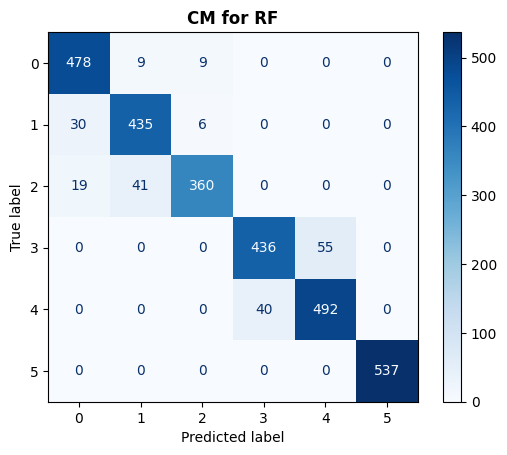

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

rf = RandomForestClassifier(n_estimators= 200, random_state = 42)
rf.fit(X_train_features, y_train_features['activity'])

y_pred_rf = rf.predict(X_test_features)

acc_rf = accuracy_score(y_test_features['activity'], y_pred_rf)
print(f'RF accuracy:{acc_rf}')

#confusion matrix
cm_rf = confusion_matrix(y_test_features['activity'], y_pred_rf)
display = ConfusionMatrixDisplay(
    confusion_matrix = cm_rf,
    display_labels = activity_labels
)
display.plot(cmap = 'Blues')
plt.title('CM for RF', fontweight = 'bold')
plt.show()

Random forest feature importance MDI

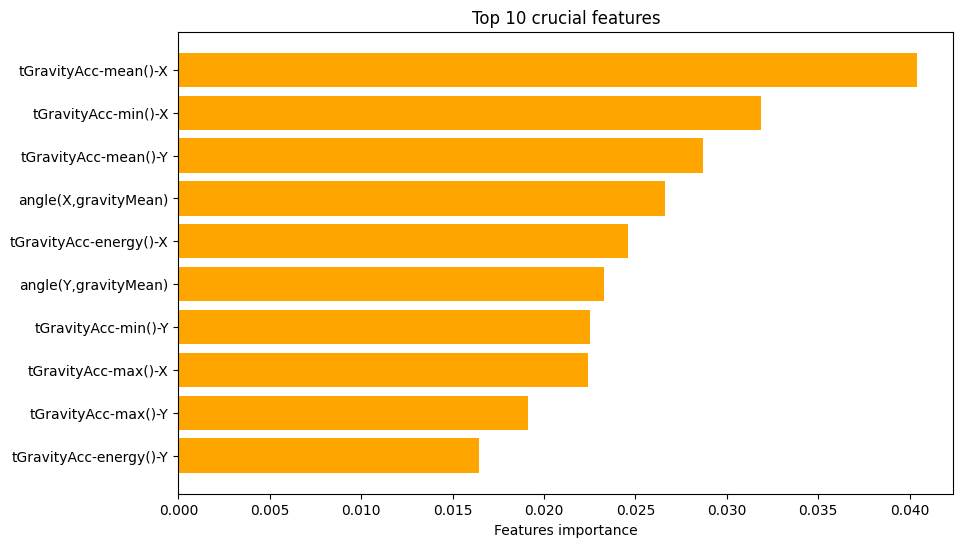

In [40]:
importances = rf.feature_importances_
idx = np.argsort(importances)[-10:]
plt.figure(figsize= (10, 6))
plt.title('Feature importances')
plt.barh(range(len(idx)), importances[idx], align = 'center', color = 'orange')
plt.yticks(range(len(idx)), features['feat_name'][idx])
plt.xlabel('Features importance')
plt.title('Top 10 crucial features')
plt.show()

**Вывод:**

* Наиболее значимыми признаками оказались признаки, связанные с гравитационной составляющей ускорения.

* Также присутствует доминирование осей X и Y, это означает, что модель в первую очередь опирается на **ориентацию тела и изменение позы**, а не резкие динамические движения.

PCA

Text(0.5, 1.0, 'Posture-based state clusters')

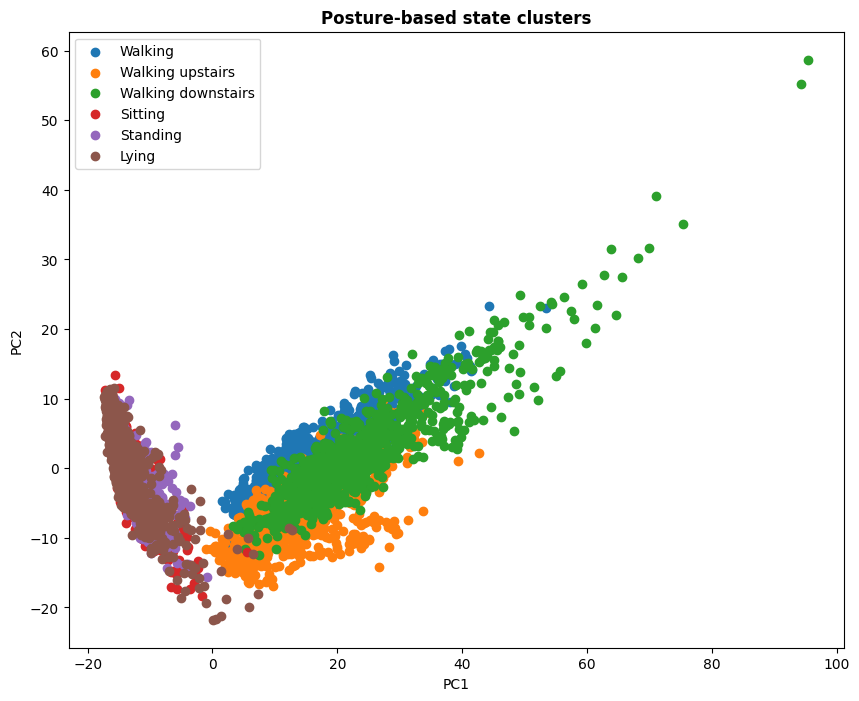

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

plt.figure(figsize = (10, 8))
for i, act in enumerate(activity_labels):
  plt.scatter(
      X_train_pca[y_train_features['activity'] == i, 0],
      X_train_pca[y_train_features['activity'] == i, 1],
      label = activity_labels[act]
  )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Posture-based state clusters', fontweight = 'bold')

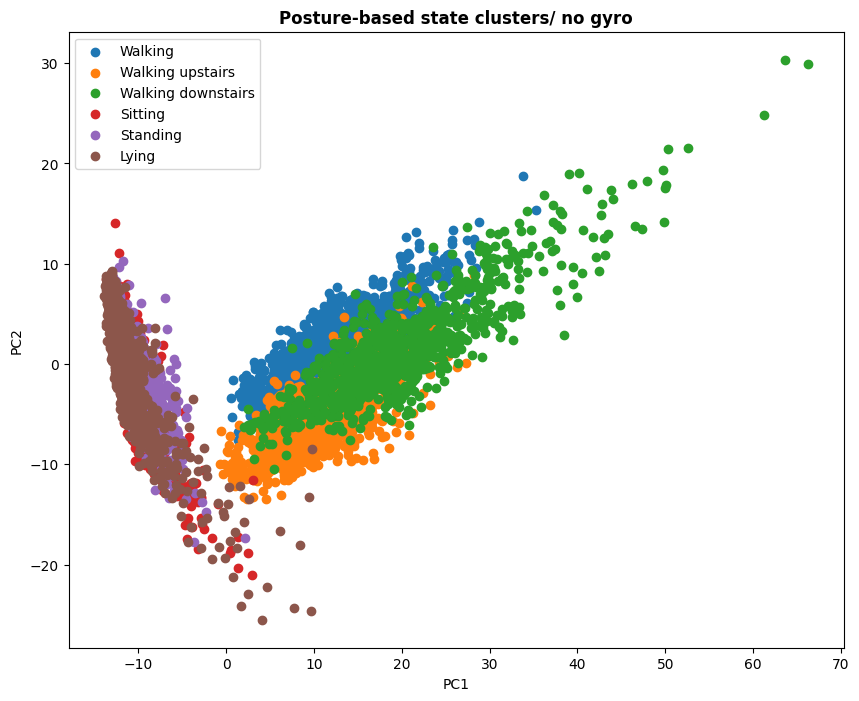

In [35]:
pca = PCA(n_components = 2)
X_train_pca_no_gyro = pca.fit_transform(X_train_feat_no_gyro)
X_test_pca_no_gyro = pca.transform(X_test_feat_no_gyro)

plt.figure(figsize = (10, 8))
for i, act in enumerate(activity_labels):
  plt.scatter(
      X_train_pca_no_gyro[y_train_features['activity'] == i, 0],
      X_train_pca_no_gyro[y_train_features['activity'] == i, 1],
      label = activity_labels[act]
  )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Posture-based state clusters/ no gyro', fontweight = 'bold')
plt.show()

Вывод:


## Сравнение устойчивости модели БЕЗ сложных признаков и с ними

Text(0.5, 1.0, 'CM for incomplete data with complex features')

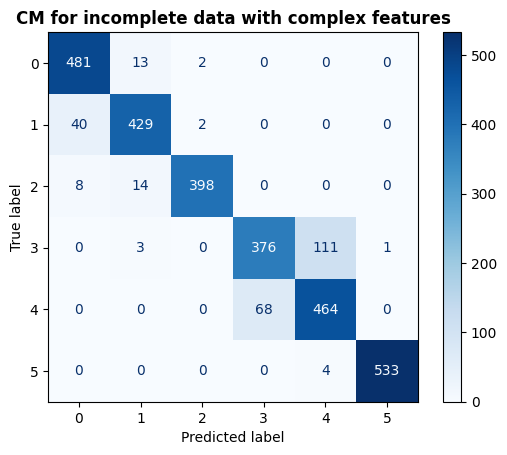

In [ ]:
import matplotlib.pyplot as plt

# incomplete data with complex features w/o gyro

y_pred_incom_f_no_gyro = baseline_incom_f.predict(X_test_feat_no_gyro)
cm_incom_f_no_gyro = confusion_matrix(y_test_features['activity'], y_pred_incom_f_no_gyro)

image = ConfusionMatrixDisplay(
    confusion_matrix = cm_incom_f_no_gyro,
    display_labels = activity_labels
)
image.plot(cmap = 'Blues')
plt.title('CM for incomplete data with complex features', fontweight = 'bold')

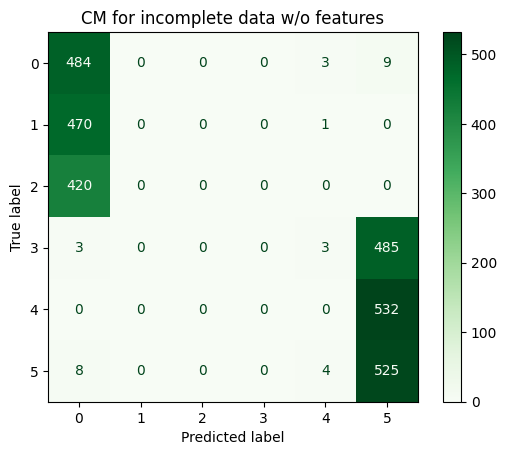

In [ ]:
# incomplete data with simple features w/o gyro
image1 = ConfusionMatrixDisplay(
    confusion_matrix = cm_incom,
    display_labels = activity_labels
)
image1.plot(cmap = 'Greens')
plt.title('CM for incomplete data w/o features')

plt.show()

In [ ]:
results = pd.DataFrame({
    'Model':[
        'Baseline: full data with simple features',
        'Baseline: incomplete data with simple features',
        'LSTM: full data with simple features',
        'LSTM: incomplete data with simple features',
        'Baseline: full data with complex features',
        'Baseline: incomplete data with complex features',
    ],
    'Accuracy':[
        baseline_acc_full,
        baseline_acc_incom,
        test_acc_full_new,
        test_acc_incom_new,
        baseline_acc_full_f,
        baseline_acc_incom_f

    ]
})
results

,Model,Accuracy
0,Baseline: full data with simple features,0.606379
1,Baseline: incomplete data with simple features,0.550730
2,LSTM: full data with simple features,0.647438
3,LSTM: incomplete data with simple features,0.621310
4,Baseline: full data with complex features,0.960299
5,Baseline: incomplete data with complex features,0.909739


**Вывод:**

 Мы видим, что с учетом сложных признаков, модель является более устойчивой, и ее качество определения разных активностей у человека возрастает

 Модель на сырых временных рядах более чувствительна к потере сенсорной информации.  

# Robustness analysis

***проверяем устойчивость модели***

Здесь я рассматриваю модель БЕЗ сложных признаков, так как complex features уже агрегированы, усреднены и нормализованы по условию датасета, поэтому masking and denoising смысл применять данные методы теряется

## Masking

В реальном мире данные с датчиков часто бывают неполными из-за временной потери сигнала(человек резко подвинулся или сенсор сместился с руки), поэтому мне нужно смоделировать такие условия, при которых я смогу оценить насколько модель устойчива к отсутсвующей информации.

Я буду использовать технику зануления, так как она поможет сохранить временную структуру.

-> Маскируем по времени

In [ ]:
X_train.shape

(7352, 128, 6)

In [ ]:
def temporal_masking(X, max_ratio = 0.3):
  '''
  X - samples, time steps, channels
  max_ratio - доля времени, которую я маскирую (30%)
  '''
  X_masked = X.copy()
  n_samples, n_time, n_channels = X_masked.shape

  mask_len = int(n_time * max_ratio)
  for n in range(n_samples):
    start = np.random.randint(0, (n_time - mask_len))
    end = start + mask_len
    X_masked[n, start:end, :] = 0.0 #no data available for a specific time period

  return X_masked

In [ ]:
X_train_masked = temporal_masking(X_train, 0.3)
X_test_masked = temporal_masking(X_test, 0.3)

Визуализируем одно случайно выбранное временное окно и один канал датчика, чтобы продемонстрировать влияние временной маскировки на исходный сигнал.

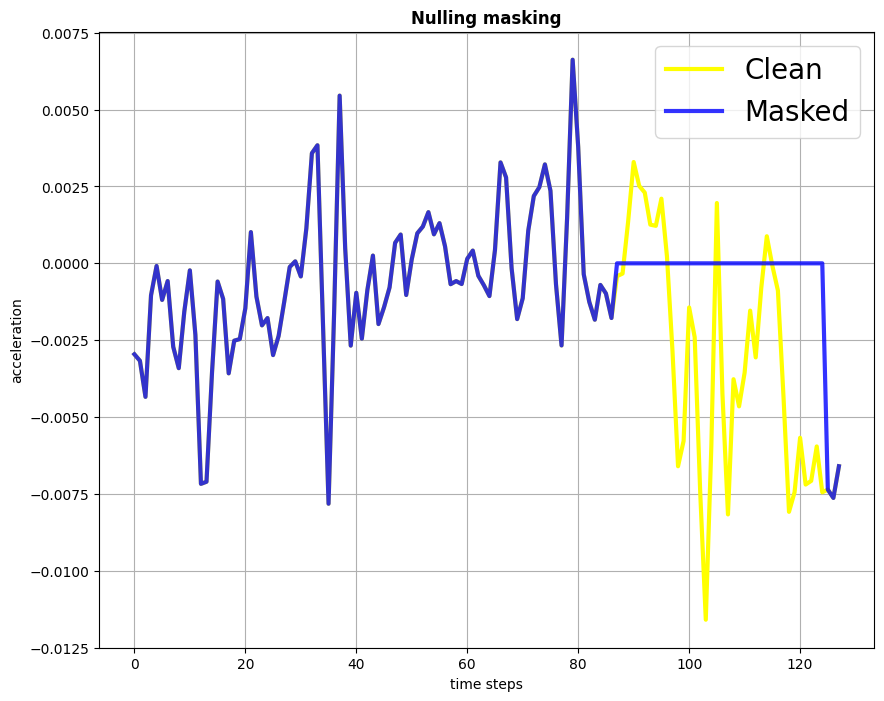

In [ ]:
samples = np.random.randint(len(X_train))
channels = 0

plt.figure(figsize = (10, 8))
plt.plot(X_train[samples, :, channels], label = 'Clean', color = 'yellow', linewidth = 3)
plt.plot(X_train_masked[samples, :, channels], label = 'Masked', color = 'blue',linewidth = 3, alpha = 0.8)
plt.title('Nulling masking', fontweight = 'bold')
plt.xlabel('time steps')
plt.ylabel('acceleration')
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

### CNN обучение

Поскольку данные имеют временной, а не пространственный характер, более подходящаы модель будет 1D CNN

Clean data:

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_clean = Sequential([
    Input(shape = (128, 6)),
    Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(
        filters=128,
        kernel_size=3,
        activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

cnn_clean.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
cnn_clean.fit(
    X_train,
    y_train_cat,
    validation_split = 0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

cnn_clean.save('cnn_clean.keras')

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.3463 - loss: 1.4121 - val_accuracy: 0.6084 - val_loss: 0.7246
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6239 - loss: 0.7000 - val_accuracy: 0.6397 - val_loss: 0.6252
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6629 - loss: 0.6227 - val_accuracy: 0.6417 - val_loss: 0.6125
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6825 - loss: 0.5831 - val_accuracy: 0.6961 - val_loss: 0.5760
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7091 - loss: 0.5511 - val_accuracy: 0.6683 - val_loss: 0.5850
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7352 - loss: 0.5407 - val_accuracy: 0.7634 - val_loss: 0.5543
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7611 - loss: 0.5085 - val_accuracy: 0.8158 - val_loss: 0.4981
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7889 - loss: 0.4643 - val_accuracy: 0.7607 - 

In [ ]:
cnn_clean = load_model('cnn_clean.keras')

In [ ]:
cnn_test_loss, cnn_test_acc = cnn_clean.evaluate(X_test, y_test_cat)

print(f'1D CNN clean data test accuracy {round(cnn_test_acc, 3)}')

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8003 - loss: 0.4999
1D CNN clean data test accuracy 0.8


Masked data:

In [ ]:
X_train_masked.shape

(7352, 128, 6)

In [ ]:
cnn_masked = Sequential([
    Input(shape = (128, 6)),
    Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(
        filters=128,
        kernel_size=3,
        activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

cnn_masked.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
cnn_masked.fit(
    X_train_masked,
    y_train_cat,
    validation_split = 0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

cnn_masked.save('cnn_masked.keras')

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.3146 - loss: 1.4252 - val_accuracy: 0.5547 - val_loss: 0.8215
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.5819 - loss: 0.8189 - val_accuracy: 0.6275 - val_loss: 0.6484
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6324 - loss: 0.6699 - val_accuracy: 0.6689 - val_loss: 0.6157
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6706 - loss: 0.6165 - val_accuracy: 0.6676 - val_loss: 0.6090
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6848 - loss: 0.5877 - val_accuracy: 0.6669 - val_loss: 0.5927
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7156 - loss: 0.5503 - val_accuracy: 0.6689 - val_loss: 0.5828
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7475 - loss: 0.5179 - val_accuracy: 0.7097 - val_loss: 0.5840
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7677 - loss: 0.4944 - val_accuracy: 0.7186 - 

In [ ]:
cnn_masked= load_model('cnn_masked.keras')

In [ ]:
cnn_test_loss_mask, cnn_test_acc_mask = cnn_masked.evaluate(X_test_masked, y_test_cat)

print(f'1D CNN masked data test accuracy {round(cnn_test_acc_mask, 3)}')

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8055 - loss: 0.5457
1D CNN masked data test accuracy 0.821


**Вывод:** Временная маскировка удаляет части сигнала, но сохраняет основную структуру активности. И так как CNN основана на локальных временных паттернах, она  компенсирует отсутствующие моменты в данных, используя оставшуюся информацию.


## Denoising

В данном блоке, я намеренно добавила зашумленные данные, чтобы проверить устойчивость модели и способность извлекат сигнал, а не шум


---

Для имитации неточностей измерений датчика был добавлен гауссовский шум

In [ ]:
def gaussian_noise(X, mean = 0.0, std_deviation = 0.1):
  noise = np.random.normal(mean, std_deviation, size = X.shape)

  return X + noise

In [ ]:
Xtrain_noise = gaussian_noise(X_train, mean = 0.0, std_deviation = 0.1)
Xtest_noise = gaussian_noise(X_test, mean = 0.0, std_deviation = 0.1)

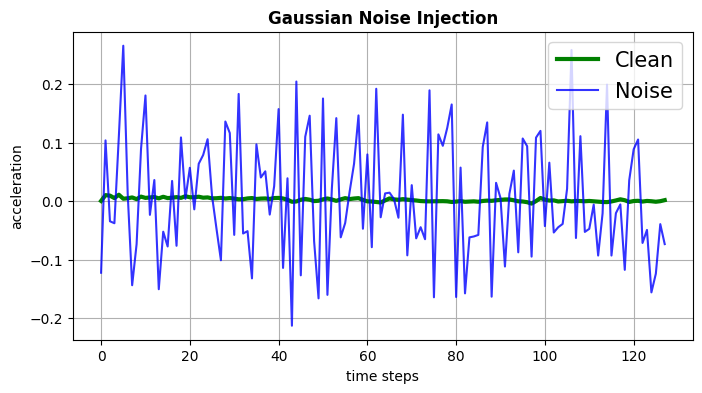

In [ ]:
samples = 0 # берем первый сенсорный сигнал
channels = 0

plt.figure(figsize = (8, 4))
plt.plot(X_train[samples, :, channels], label = 'Clean', color = 'green', linewidth = 3)
plt.plot(Xtrain_noise[samples, :, channels], label = 'Noise', color = 'blue', alpha = 0.8)
plt.title('Gaussian Noise Injection', fontweight = 'bold')
plt.xlabel('time steps')
plt.ylabel('acceleration')
plt.legend(fontsize = 15)
plt.grid(True)
plt.show()

Визуализируем одно случайно выбранное временное окно и один канал датчика, чтобы продемонстрировать влияние временной маскировки на исходный сигнал.


---


Шум увеличил изменчивость сигнала, но сохранил общую картину движения

### CNN обучение

In [ ]:
cnn_noised = Sequential([
    Input(shape = (128,6)),
    Conv1D(
        filters=64,
        kernel_size=3,
        activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(
        filters=128,
        kernel_size=3,
        activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

cnn_noised.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
cnn_noised.fit(
    Xtrain_noise,
    y_train_cat,
    validation_split = 0.2,
    epochs=10,
    batch_size=64,
    verbose=1
)

cnn_noised.save('cnn_noised.keras')

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.2966 - loss: 1.5418 - val_accuracy: 0.6023 - val_loss: 0.8202
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6272 - loss: 0.7897 - val_accuracy: 0.6241 - val_loss: 0.6618
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6645 - loss: 0.6598 - val_accuracy: 0.6431 - val_loss: 0.6132
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6652 - loss: 0.6253 - val_accuracy: 0.6479 - val_loss: 0.6225
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6774 - loss: 0.5898 - val_accuracy: 0.6547 - val_loss: 0.5920
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6996 - loss: 0.5743 - val_accuracy: 0.6832 - val_loss: 0.5873
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6991 - loss: 0.5730 - val_accuracy: 0.6669 - val_loss: 0.5857
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7036 - loss: 0.5566 - val_accuracy: 0.6880 - v

In [ ]:
cnn_noised= load_model('cnn_noised.keras')

In [ ]:
cnn_test_loss_noise, cnn_test_acc_noise = cnn_masked.evaluate(Xtest_noise, y_test_cat)

print(f'1D CNN noised data test accuracy {round(cnn_test_acc_noise, 3)}')

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5497 - loss: 2.0704
1D CNN noised data test accuracy 0.575


## Confusion matrix - сравнение модели

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


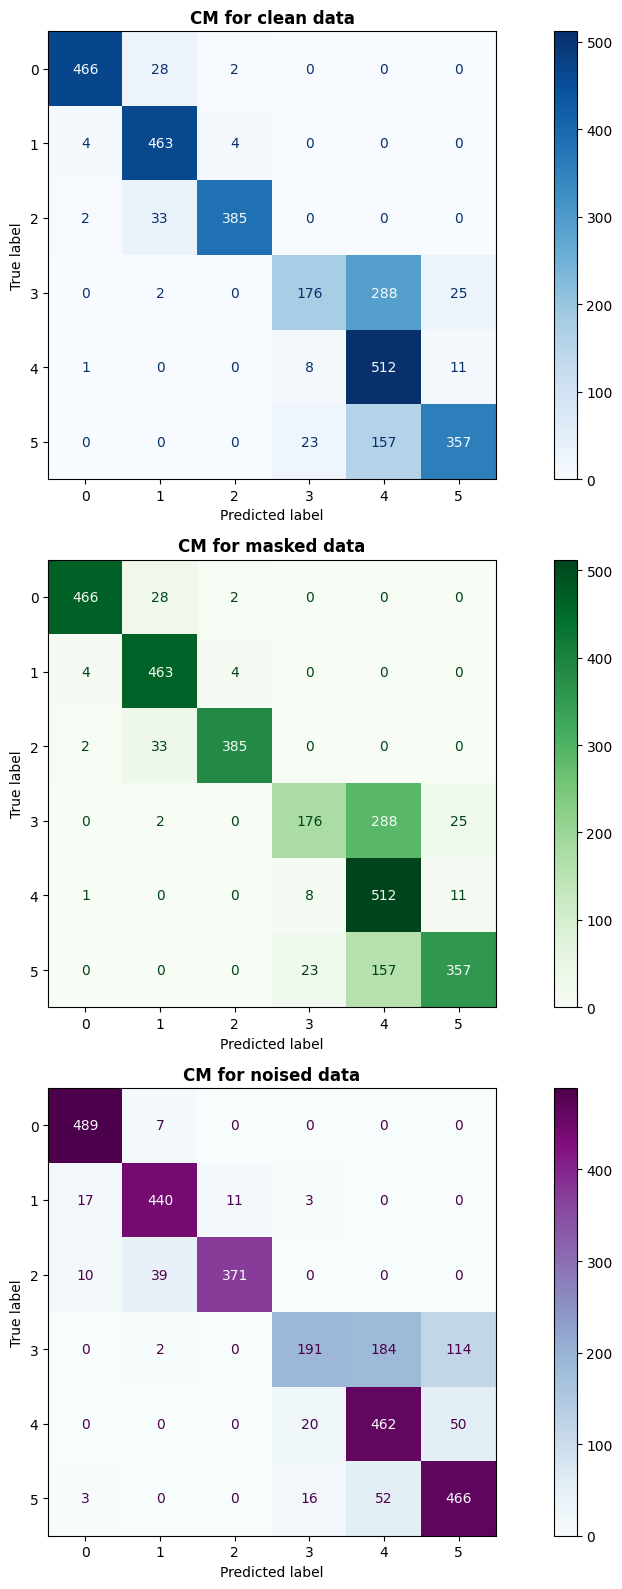

In [ ]:
# clean data
y_pred_clean = np.argmax(cnn_clean.predict(X_test), axis=1)
cm_clean = confusion_matrix(y_test['activity'], y_pred_clean)

plt.figure(figsize = (12, 16))
plt.subplot(3, 1, 1)
ConfusionMatrixDisplay(cm_clean).plot(cmap = 'Blues', ax=plt.gca())
plt.title('CM for clean data', fontweight = 'bold')

# masked data
y_pred_mask = np.argmax(cnn_masked.predict(X_test_masked), axis=1)
cm_mask = confusion_matrix(y_test['activity'], y_pred_mask)

plt.subplot(3, 1, 2)
ConfusionMatrixDisplay(cm_clean).plot(cmap = 'Greens', ax=plt.gca())
plt.title('CM for masked data', fontweight = 'bold')

# noised data
y_pred_noise = np.argmax(cnn_noised.predict(Xtest_noise), axis=1)
cm_nois = confusion_matrix(y_test['activity'], y_pred_noise)

plt.subplot(3, 1, 3)
ConfusionMatrixDisplay(cm_mask).plot(cmap = 'BuPu', ax=plt.gca())
plt.title('CM for noised data', fontweight = 'bold')
plt.tight_layout()
plt.show()

**Вывод:**

Рассмотрим качество и количество положительных метрик

In [ ]:
from sklearn.metrics import f1_score, recall_score, classification_report
y_true = y_test
y_pred_clean = np.argmax(cnn_clean.predict(X_test), axis = 1)
y_pred_masked = np.argmax(cnn_masked.predict(X_test_masked), axis = 1)
y_pred_noised = np.argmax(cnn_noised.predict(Xtest_noise), axis = 1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
macro_f1_clean = f1_score(y_true, y_pred_clean, average = 'macro')
print(f'F1_clean: {macro_f1_clean:.3f}\n')
macro_f1_masked = f1_score(y_true, y_pred_masked, average = 'macro')
print(f'F1_masked: {macro_f1_masked:.3f}\n')
macro_f1_noised = f1_score(y_true, y_pred_noised, average = 'macro')
print(f'F1_noise: {macro_f1_noised:.3f}\n\n')

print('CLEAN:\n')
recall_activity_clean = recall_score(y_true, y_pred_clean, average = None)
for a, r in enumerate(recall_activity_clean):
  print(f'Activity: {a}, recall: {r:.3f}\n')

print('MASKED:\n')
recall_activity_masked = recall_score(y_true, y_pred_masked, average = None)
for a, r in enumerate(recall_activity_masked):
  print(f'Activity: {a}, recall: {r:.3f}\n')

print('NOISED:\n')
recall_activity_noised = recall_score(y_true, y_pred_noised, average = None)
for a, r in enumerate(recall_activity_noised):
  print(f'Activity: {a}, recall: {r:.3f}\n')

F1_clean: 0.800

F1_masked: 0.814

F1_noise: 0.673


CLEAN:

Activity: 0, recall: 0.940

Activity: 1, recall: 0.983

Activity: 2, recall: 0.917

Activity: 3, recall: 0.358

Activity: 4, recall: 0.962

Activity: 5, recall: 0.665

MASKED:

Activity: 0, recall: 0.986

Activity: 1, recall: 0.934

Activity: 2, recall: 0.883

Activity: 3, recall: 0.389

Activity: 4, recall: 0.868

Activity: 5, recall: 0.868

NOISED:

Activity: 0, recall: 0.919

Activity: 1, recall: 0.934

Activity: 2, recall: 0.898

Activity: 3, recall: 0.228

Activity: 4, recall: 0.761

Activity: 5, recall: 0.367



In [ ]:
activity_labels = {
    0: 'Walking',
    1: 'Walking upstairs',
    2: 'Walking downstairs',
    3: 'Sitting',
    4: 'Standing',
    5: 'Lying'
}

**Выводы:**

Сверху представлено сравнение показателей F1-меры и полноты для каждого класса на чистых, замаскированных и зашумленных наборах данных.
Результаты показывают, что временная маскировка в основном влияет на статическую активность, в то время как динамические движения остаются устойчивыми.

*Основные моменты:*


1.   Динамические активности (0-2) устойчивы и к masking и к denoising
2.   Activity 3 (Sitting) резко деградирует при masking и denoising
3.   Activity 3 (Lying) также неустойчив при зашумлении данных
4.   Несмотря на неполноту и зашумление качество положительных предсказаний не страдает


# RP

Необработанные сигналы часто содержат сложные временные зависимости. Здесь я буду исследовать рекуррентный анализ, различие в динамике между 6 видами активности.

[литература](https://habr.com/ru/articles/145805/)

In [41]:
def phase_space_reconstruction(signal, m = 2, tau = 10):
    N = len(signal)
    M = N - (m - 1) * tau
    X = np.zeros((M, m))

    for i in range(m):
        X[:, i] = signal[i * tau : i * tau + M]

    return X

In [42]:
from scipy.spatial.distance import cdist

def recur_plot(signal, m = 2,tau = 10):
  epsilon = 0.1 * np.std(signal)

  X_embedded = phase_space_reconstruction(signal, m, tau)
  D = cdist(X_embedded, X_embedded, metric = 'euclidean')
  RP = (D < epsilon).astype(int)
  return RP


Построив визуализацию, можно выявить следующие моменты:


*   Диагональные линии будут указывать на периодичность движения
*   Однородные области на статичное поведение
*   Сложные текстуры на динамическую активность



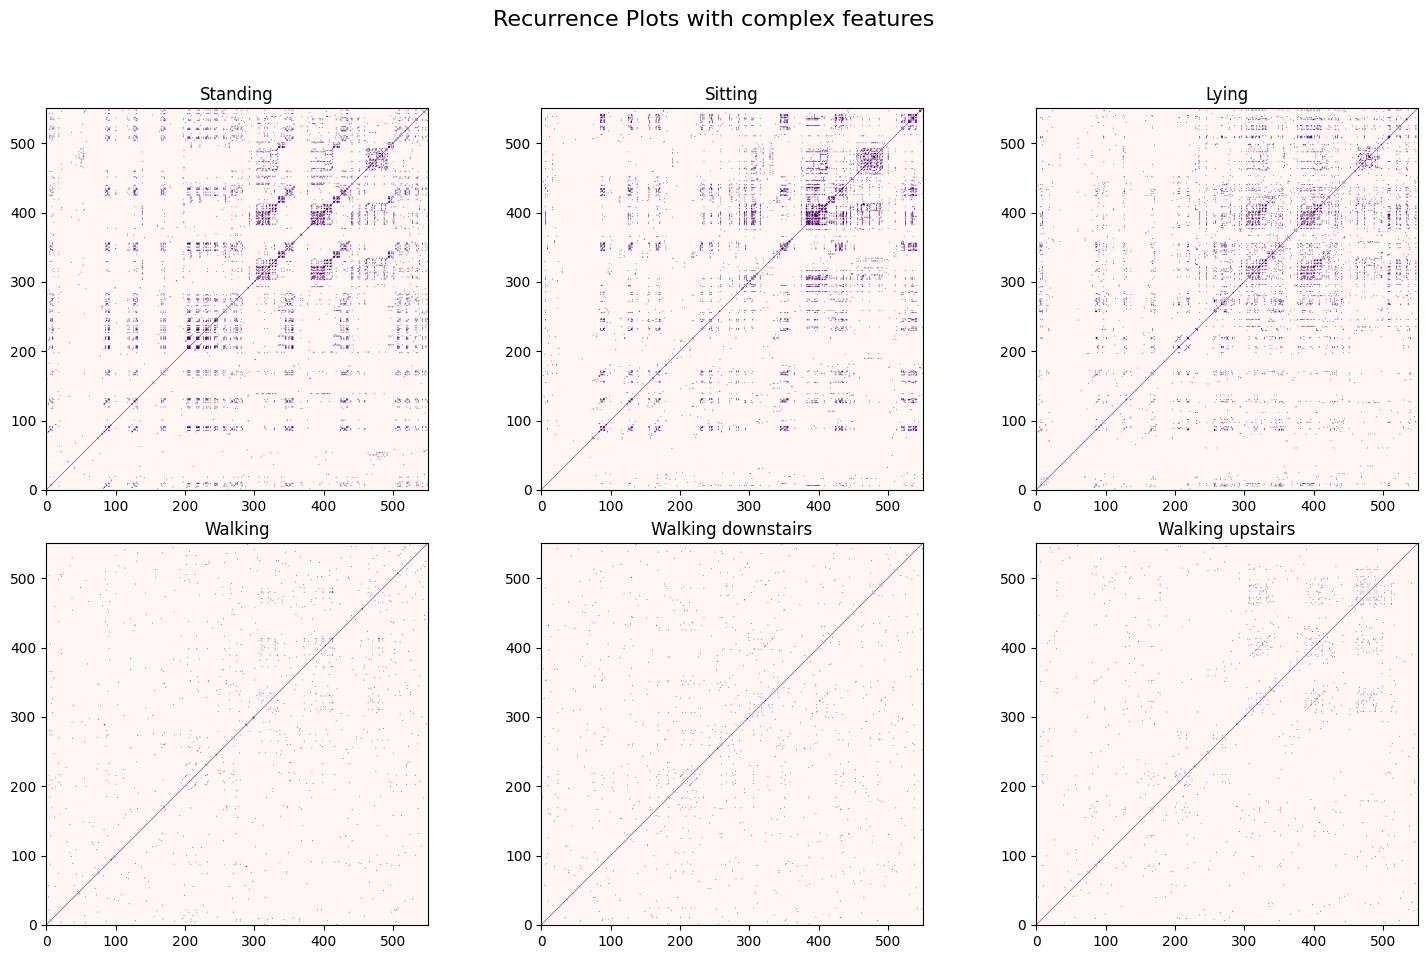

In [51]:
plt.figure(figsize = (15, 10))

for i, act in enumerate(activity_ex):
  idx = y_train_features[y_train_features['activity'] == act].index[0]

  signal_features = X_train_features[idx, :]

  RP = recur_plot(signal_features)

  plt.subplot(2, 3, i + 1)
  plt.imshow(RP, cmap='RdPu', origin='lower')
  plt.title(f'{activity_labels[act]}')

plt.suptitle('Recurrence Plots with complex features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Выводы:**

*   Standing / Sitting / Lying
1. имеется разброс точек, которые указывают на стохастическое (случайное) поведения, без закономерностей, при котором система не возвращается ни к одному из предыдущих состояний осмысленным или структурированным образом.
2. модели указывают на группы схожих состояний(статик активности)

*   Walking (up/down)
1. Присутствуют четкие диагональные линии
2. Повторяются такие движения как - повороты корпуса / движение руками (так как вне диагонали присутвует большое кол во точек)
3. Однако модель по прежнему легко распознает данное состояние



**Выводы:**
* Удаление сенсора значительно ухудшает качество реконструкции, однако при рассмотрении модели со сложными признаками без простого обнуления признаков гироскопа,  можно сделать вывод, что модель устойчива, даже при таких состояниях когда один из датчиков отлетает/ теряет свое свойство или вовсе не включен в устойство.
* Мaскирование влияет на временную согласованность дaнных, однако не теряет точность модели
* Шумоподaвление улучшает стабильность сигнала, но не восстанавливает недостающую информацию, из за чего можно сделать вывод, что модель менее устойчива к постонним шумам.
* График рекуррентности показывает, что статические и динамические данные хорошо различимы, и все виды имеют ритм, однако статичекие активности не преобладают способностью возвращаться к предыдущему состоянию структурированным образом